
----
- Name: Marlene Lin
- UID: 105329845
- Final project - option 2 for CS M121 W23
---- 
# Psuedoalignment Implementation
**Goal:** Given some RNA-seq data in FASTA format, find the vector of equivalence class counts. 

The pseudoalignment procedure should take in:
- (1) an index from gene notation, or, a way of corresponding isoform name to the actual sequence (ref genome: *chr11*)
- (2) RNA-seq data (reads: *reads.tar.gz*)
- (3) a k-mer length (ideally between 21 ~ 36) 

The output would be a table like:

 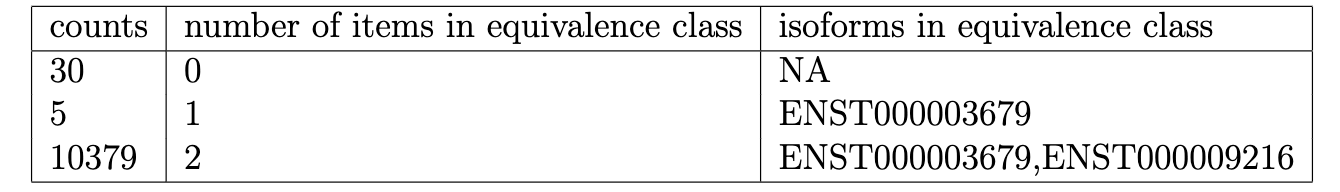
- isoforms in eq. class
- number of items in that eq. class: how many isoforms are in the eq. class
- counts: number of reads that map to the equivalence class
An equivalence class is a set of isoform targes that the read could potentially be from/map to.

To see the final implementation, go to the pseudoalign - Obatining table... section of this notebook. 




## Read data  
The RNA-seq data and ref genome are both in FASTA forma, which we would parse with the biopython library.

 


In [ ]:
!pip install Bio

In [1]:
import gzip
from Bio import SeqIO
import pandas as pd 
from matplotlib import pyplot as plt

### Obtaining RNA-seq reads:  

The RNA-seq reads are all of length 100. In the read description, it gave an alignment result that we could potentially use to check our work.

In [2]:
reads = []
with gzip.open("reads.fasta.gz", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fasta"):
        des = seq_record.description.split(';')[0]
        mate1 = seq_record.description.split(';')[1]
        mate2 = seq_record.description.split(';')[2]
        id = des.split('/')[0]
        gene = des.split('/')[1]
        seq = str(seq_record.seq)
        length = len(seq_record.seq)
        d = {
         'mate1':mate1,
         'mate2':mate2,
         'id':id,
         'seq':seq,
         'length':length,
         'gene':gene
         }
        reads.append(d)

In [138]:
reads[1]

{'mate1': 'mate1:221-320',
 'mate2': 'mate2:302-400',
 'id': 'read2',
 'seq': 'CCCCCGTGCTGCCCTGAGGAAGTTGAAGCTCCTCGCTGCTTCTGGCACTTCAGCGGGAAGTTGGTTGGGGCGGGATCGCGCGCCCTCTGGTGGCGCCATG',
 'length': 100,
 'gene': 'ENST00000410108'}

In [139]:
#check for missing
for d in reads:
    if len(d['seq']) < 10:
        print(d)

### Indexing: Optaining the reference genome: (chr11)   

The target sequences have varied lengths, as shown in the histogram. 

In [3]:
chr11 = []
with open("chr11_transcriptome.fasta", "rt") as handle11:
    for seq_record in SeqIO.parse(handle11, "fasta"):
        gene = seq_record.description
        seq = str(seq_record.seq)
        length = len(seq_record)
        d = {
         'seq':seq,
         'length':length,
         'gene':gene
         }
        chr11.append(d)

In [142]:
chr11[1]

{'seq': 'CCACGTCTGAGGCGGCTGTGGCCGCGTCGGTGTCCGCGTCGAGGAGCCGGGGCAGGGCACGATGGCGGACTGGGCTCGGGCTCAGAGCCCGGGCGCTGTGGAAGAGATTCTAGACCGGGAGAACAAGCGAATGGCTGACAGCCTGGCCTCCAAAGTCACCAGGCTCAAATCGCTCGCCCTGGACATCGATAGGGATGCAGAGGATCAGAACCGGTACCTGGATGGCATGGTAAGGGCCCACGGTGTGCGTGTATCAGTGCCCTGCCCTAGCACTACCTGCTGCAGAGCCTGCAGTGTCTCCTTCAGCACTGGTGCGGGTGGGTGGTCAAATCACCACTTCTGTGTGATCTTGCTGGGATTCCTCCCTTAGGACTCGGATTTCACAAGCATGACCAGCCTGCTTACAGGGAGCGTGAAGCGCTTTTCCACAATGGCAAGGTCCGGACAAGACAACCGGAAGCTTCTATGTGGCATGGCCGTGGGTCTAATTGTGGCCTTCTTCATCCTCTCCTACTTCTTGTCCAGGGCAAGGACGTGAGCCAGTGGGAGCTGGTGTCTGTGGGTGCCAAGGGCAGCCAGGGTCTTCCCTGCCTGGTGTTTTGGGCTCCAGAGGACTTACCTACAAAATACTCCTTTGCAATGATAATTGTGGGTCAGGAATCTTCTTCCTGTGTGGCAGGAGGCTGCGGCTGCCTGTGACCTGATGAGCTCATGTTGGCTGGTCCCATGTGTGAAAGGGACTCTCTCGGGGAAACCAAGGCCCAGCCCCTCCCCCCTCCCCCAGGTGCTAGAGAGCCAGGCAGAGCTGGGGCCACAGCGTGTCTGGAGAAGCCAGGTCTGAGCAGAGCAGCTGGTGAATCCCAGACGTGGCCACCTGTGGCTTGCAGCCCTTCTCCCCGCGCTTGGGACTCTGACATCTTAAGGCTGCACGGTCGTGTCCTTGTCTGGGTGAGGCCATGTCTGTGATCCAAGGTTCCTGGAACTGACACAG

Text(0.5, 1.0, 'Isoform target length distribution')

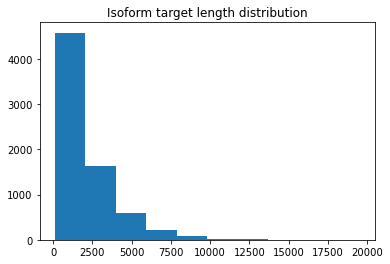

In [401]:
plt.hist([g['length'] for g in chr11])
plt.title('Isoform target length distribution')

## Equivalence classes

### Define helper functions for equivalence counts: 
1) Generate a list of k-mers from a sequence based on k-mer length
2) Get the reverse complement of a strand

In [6]:
def kmers(k,seq):
    if k < 1:
        raise "k must be positive"
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

In [7]:
seq = 'ACTGCATATA'
k = 3
print(kmers(k,seq))


['ACT', 'CTG', 'TGC', 'GCA', 'CAT', 'ATA', 'TAT', 'ATA']


In [8]:
def rev(seq):
    r = "".join(reversed(seq))
    complement = {'A':'T','C':'G','G':'C','T':'A'}
    return ''.join([complement[base] for base in r])

In [407]:
print(seq)
print(rev(seq))

ACTGCATATA
TATATGCAGT


### Obtain all equivalence classes and isoforms in each eq. class. 

In this part we would use a hash table (or python dict, where the key is not hashed to some number/string but just the kmer themselves) to store the equivalence classes. 

Note that hash table is used to implement both dict and set in python.


In [9]:
def equivalence(k,sequence):
    if k > sequence[0]['length']:
        raise 'k should be smaller than isoform length'
    eq = dict()
    for s in sequence:
        ks = kmers(k,s['seq'])
        for mer in ks:
            #if the kmer is not already in the dict, return an empty list/set
            #convert that to list, and concat the new isoform with that kmer
            #conver to set again to remove duplicate
            eq.update({mer:set(list(eq.get(mer,list())) + [s['gene']])})
    return eq


In [172]:
eq22 = equivalence(22,chr11)

In [173]:
print(list(eq22.keys())[0],' ',list(eq22.values())[0])

GCCACGTCTGAGGCGGCTGTGG   {'ENST00000410108', 'ENST00000382762'}


## Psuedoalign

To account for reverse strand, we do the alignment twice, the first time with the original read, the second time with the reverse complementary of the original read. For each direction, we take the intersection of the lists of equivalence classes each kmer of the read maps to. When returning the set of isoforms the read could map to, we take the union of forward's and reverse's mapping.

Example of pseudo-align

In [10]:
read1 = reads[1]
def psuedoalign(read,k,eqdict):
    #original
    kmso = [km for km in kmers(k,read)]
    eqclasso = [eqdict.get(kmr,set()) for kmr in kmso] 
    os = set.intersection(*eqclasso)
    #reverse 
    kmsr = [km for km in kmers(k,rev(read))]
    eqclassr = [eqdict.get(kmr,set()) for kmr in kmsr] 
    rs = set.intersection(*eqclassr)
    #return the non-empty set
    return list(rs.union(os))


### Answer checking

In [410]:
iso = psuedoalign(read1['seq'],22,eq22)
print('p-aligned: ',iso[0])
print('labeled: ',read1['gene'])

p-aligned:  ENST00000410108
labeled:  ENST00000410108


### Final Implementation  
#### Obtaining the table from reads, reference, and k-length  

wrapper please see visualization part for the final table for varying k-mer lengths = 22,28,36

Just a wrapper of the above that takes care of missing bases in reads. Mostly just 1, a very, very few with 2 (that we just pass).


In [414]:
n_ct = []
for r in reads:
    if 'N' in r['seq']:
        n_ct.append(r['seq'].count('N'))
print("number of N's missing: "+str(set(n_ct)))
print("number of fragments: "+str([n_ct.count(i) for i in set(n_ct)]))

number of N's missing: {1, 2}
number of fragments: [5598, 12]


In [11]:
def palign(reads,k,eqdict):
    align = {} #alignment results

    for r in reads:
        seq = r['seq']
        # We only handle the missing one base in read case
        # By substituting in A/T/C/G
        if seq.count('N') == 1:
            for fix in ['A','T','C','G']:
                seq = seq.replace('N',fix)
                iso = psuedoalign(seq,k,eqdict)
                if iso: #append the first sub that gives non empty alignment
                    break
                #if not, empty list would be appended
        elif seq.count('N') == 0:
            iso = psuedoalign(seq,k,eqdict)
        # We ignore the missing two bases cases because only 12

        # We sort the list of aligned isoforms and then convert that to string
        ali = list(iso)
        num = len(iso) #nums of isoforms in the eq class
        ali.sort()
        eqstr = "".join(i+', ' for i in ali)
        align.update({eqstr:{'counts':align.get(eqstr,{'counts':0})['counts']+1,'num':num}})

    return pd.DataFrame({
        'isoforms in the eq. class':list(align.keys()),
        'counts':[d['counts'] for d in align.values()],
        'num. of isoforms in the eq. class':[d['num'] for d in align.values()]}).sort_values('num. of isoforms in the eq. class')

In [449]:
# The actual alignment of each read to the isoform targets took approximately 2min
result22 = palign(reads,22,eq22)

In [461]:
result = result22.sort_values('num. of isoforms in the eq. class')
result.head()

,isoforms in the eq. class,counts,num. of isoforms in the eq. class
2,,230484,0
8269,"ENST00000540830,",13,1
8828,"ENST00000681339,",1,1
8827,"ENST00000280346,",1,1
2425,"ENST00000323959,",2,1


In [450]:
print(sum(result22.counts)) 
print(len(reads))

1282526
1282526


In [465]:
eq28 = equivalence(28,chr11)
eq36 = equivalence(36,chr11) 
result28 = palign(reads,28,eq28)
result36 = palign(reads,36,eq36)

## Visualization

Plotting the counts of reads mapping to equivalence classes of certain sizes v.s. certain sizes. For kmer length = 22,28,36, the visualizations are very similar, only very slight differences in counts.

In [471]:
def vis(res,k,ax): 
    num = 'num. of isoforms in the eq. class'
    plot = res.groupby(num)['counts'].agg(sum).reset_index(0)
    plt.sca(ax)
    plt.scatter(plot.counts,plot[num])
    plt.xlabel('counts of reads')
    plt.ylabel('number of isoforms')
    plt.title('kmer length = '+str(k))
    return plot

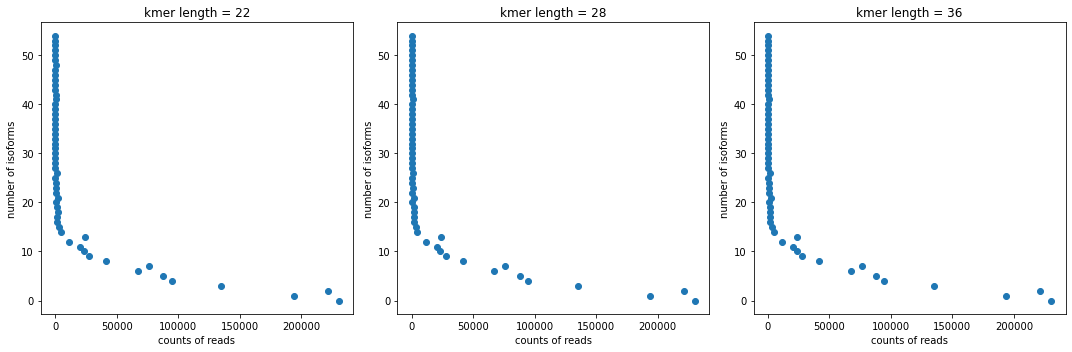

In [474]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
tbl22 = vis(result22,22,ax[0])
tbl28 = vis(result28,28,ax[1])
tbl36 = vis(result36,36,ax[2])
#tbl42 = vis(result42,42,ax[3])
plt.tight_layout()

## Discussion 

1) What I did: 
- Generate kmers based on a lists of given isoform targets (from chromosome 11)

- Generate kmer-based equivalence classes, for a certain kmer, what isoforms has it

- Write a psuedoalign function to align a read to equivalence classes which also handles the missing base ('N' in sequence) and the reverse complementary sitution.   
    - The implementaiton is hash table (python dict) based. 
    - The psuedoalignment is based on intersection, no backtracking or skipping if at one point the intersection gives an empty set.

- The implementation time of the whole process is roughly:
    - Create equivalence classes/indexing?: 0.5 ~ 1min
    - Psuedoalign: 2.5 ~ 3min


2) Potential problem: 

- From the looks of it, I have about 22% of reads that ended up not being aligned to anything. This is proabably because my implementation has no 'skipping' or 'backtracking', so many reads are simply discarded when one of their kmers fail to match anything.  


3) Interesting part: 

- When the kmer length is somewhere between 21-36, the equivalence class total counts are the same, just slight differences in the counts for each. Noticeably, the shape of the visualization of #isoform in eq.class of a certain size v.s. counts of reads mapping to classes of that size shows us that there are a few kmers/segment that could be mapped to a lot of taret isoforms. It's possible that they are common segments in genes. 